# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [8]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [9]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


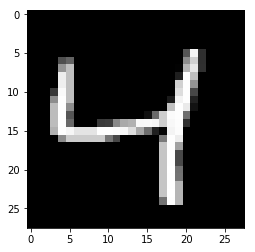

In [10]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [11]:
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Activation, Cropping2D, Lambda
from keras.models import Model, Sequential
from keras import losses

## Using UpSampling

In [12]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = Input(shape = [28, 28, 1], dtype='float32', name='input')


#keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
#keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)
#keras.layers.UpSampling2D(size=(2, 2), data_format=None)
#keras.layers.Cropping2D(cropping=((0, 0), (0, 0)), data_format=None)


### Encoder
conv1 = Conv2D(16, (5, 5), padding='same', strides=(1, 1), activation='relu')(inputs_)
# Now 28x28x16

maxpool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv1)
# Now 14x14x16

conv2 = Conv2D(8, (5, 5), padding='same', strides=(1, 1), activation='relu')(maxpool1)
# Now 14x14x8

maxpool2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv2)
# Now 7x7x8

encoded = Conv2D(8, (5, 5), padding='same', strides=(1, 1), activation='relu')(maxpool2)
# Now 7x7x8

#encoded = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv3)
#encoded = tf.layers.max_pooling2d(conv3, pool_size=(3, 3), strides=(2, 2), padding='same')
# Now 4x4x8



### Decoder

upsample1 = UpSampling2D(size=(1, 1))(encoded)
# Now 7x7x8

conv4 = Conv2D(8, (5, 5), padding='same', strides=(1, 1), activation='relu')(upsample1)
# Now 7x7x8

upsample2 = UpSampling2D(size=(2, 2))(conv4)
# Now 14x14x8

conv5 = Conv2D(8, (5, 5), padding='same', strides=(1, 1), activation='relu')(upsample2)
# Now 14x14x8

upsample3 = UpSampling2D(size=(2, 2))(conv5)
# Now 28x28x8

conv6 = Conv2D(16, (5, 5), padding='same', strides=(1, 1), activation='relu')(upsample3)
# Now 28x28x16

logits = Conv2D(1, (5, 5), padding='same', strides=(1, 1))(conv6)
#Now 28x28x1


# Pass logits through sigmoid to get reconstructed image
decoded = Activation('sigmoid')(logits)


model = Model(inputs=inputs_, outputs=decoded)
model.compile(loss=losses.binary_crossentropy, optimizer='Adam')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 8)         3208      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 8)           1608      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 7, 7, 8)           0         
__________

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [13]:
sess = tf.Session()
K.set_session(sess)

In [14]:
batch = mnist.train.next_batch(mnist.train.num_examples)

epochs = 20
batch_size = 200

imgs = batch[0].reshape((-1, 28, 28, 1))

model.fit(imgs, imgs,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)


Epoch 1/20
60000/60000 [==============================] - 8s 130us/step - loss: 0.1845
Epoch 2/20
60000/60000 [==============================] - 7s 123us/step - loss: 0.0999
Epoch 3/20
60000/60000 [==============================] - 7s 124us/step - loss: 0.0917
Epoch 4/20
60000/60000 [==============================] - 7s 124us/step - loss: 0.0877
Epoch 5/20
60000/60000 [==============================] - 7s 125us/step - loss: 0.0849
Epoch 6/20
60000/60000 [==============================] - 7s 125us/step - loss: 0.0830
Epoch 7/20
60000/60000 [==============================] - 7s 125us/step - loss: 0.0815
Epoch 8/20
60000/60000 [==============================] - 8s 125us/step - loss: 0.0804
Epoch 9/20
60000/60000 [==============================] - 7s 123us/step - loss: 0.0794
Epoch 10/20
60000/60000 [==============================] - 7s 123us/step - loss: 0.0786
Epoch 11/20
60000/60000 [==============================] - 7s 124us/step - loss: 0.0779
Epoch 12/20
60000/60000 [================

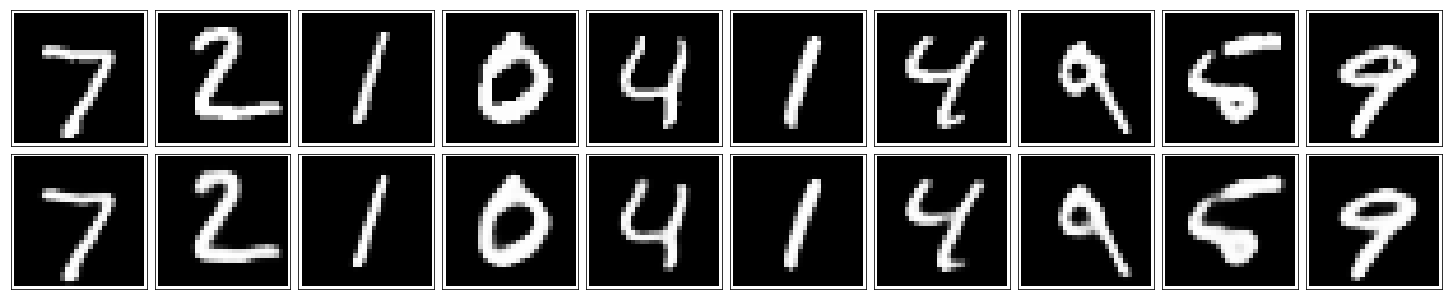

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = model.predict(in_imgs.reshape((10, 28, 28, 1)))

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [16]:
del model
K.clear_session()
sess.close()

## Using Resize

In [17]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = Input(shape = [28, 28, 1], dtype='float32', name='input')


#keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
#keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)
#keras.layers.UpSampling2D(size=(2, 2), data_format=None)
#keras.layers.Cropping2D(cropping=((0, 0), (0, 0)), data_format=None)


### Encoder
conv1 = Conv2D(16, (5, 5), padding='same', strides=(1, 1), activation='relu')(inputs_)
# Now 28x28x16

maxpool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv1)
# Now 14x14x16

conv2 = Conv2D(8, (5, 5), padding='same', strides=(1, 1), activation='relu')(maxpool1)
# Now 14x14x8

maxpool2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv2)
# Now 7x7x8

conv3 = Conv2D(8, (5, 5), padding='same', strides=(1, 1), activation='relu')(maxpool2)
# Now 7x7x8

encoded = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv3)
#encoded = tf.layers.max_pooling2d(conv3, pool_size=(3, 3), strides=(2, 2), padding='same')
# Now 4x4x8



### Decoder

upsample1 = Lambda(lambda image: K.tf.image.resize_nearest_neighbor(image, (7, 7)))(encoded)
# Now 7x7x8

conv4 = Conv2D(8, (5, 5), padding='same', strides=(1, 1), activation='relu')(upsample1)
# Now 7x7x8

upsample2 = Lambda(lambda image: K.tf.image.resize_nearest_neighbor(image, (14, 14)))(conv4)
# Now 14x14x8

conv5 = Conv2D(8, (5, 5), padding='same', strides=(1, 1), activation='relu')(upsample2)
# Now 14x14x8

upsample3 = Lambda(lambda image: K.tf.image.resize_nearest_neighbor(image, (28, 28)))(conv5)
# Now 28x28x8

conv6 = Conv2D(16, (5, 5), padding='same', strides=(1, 1), activation='relu')(upsample3)
# Now 28x28x16

logits = Conv2D(1, (5, 5), padding='same', strides=(1, 1))(conv6)
#Now 28x28x1


# Pass logits through sigmoid to get reconstructed image
decoded = Activation('sigmoid')(logits)


model = Model(inputs=inputs_, outputs=decoded)
model.compile(loss=losses.binary_crossentropy, optimizer='Adam')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         3208      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           1608      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
__________

In [18]:
sess = tf.Session()
K.set_session(sess)

In [19]:
batch = mnist.train.next_batch(mnist.train.num_examples)

epochs = 20
batch_size = 200

imgs = batch[0].reshape((-1, 28, 28, 1))

model.fit(imgs, imgs,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)


Epoch 1/20
60000/60000 [==============================] - 8s 126us/step - loss: 0.2166
Epoch 2/20
60000/60000 [==============================] - 7s 124us/step - loss: 0.1302
Epoch 3/20
60000/60000 [==============================] - 7s 124us/step - loss: 0.1183
Epoch 4/20
60000/60000 [==============================] - 7s 125us/step - loss: 0.1122
Epoch 5/20
60000/60000 [==============================] - 8s 126us/step - loss: 0.1077
Epoch 6/20
60000/60000 [==============================] - 8s 126us/step - loss: 0.1046
Epoch 7/20
60000/60000 [==============================] - 8s 125us/step - loss: 0.1022
Epoch 8/20
60000/60000 [==============================] - 8s 126us/step - loss: 0.1004
Epoch 9/20
60000/60000 [==============================] - 8s 126us/step - loss: 0.0987
Epoch 10/20
60000/60000 [==============================] - 8s 126us/step - loss: 0.0973
Epoch 11/20
60000/60000 [==============================] - 8s 126us/step - loss: 0.0963
Epoch 12/20
60000/60000 [================

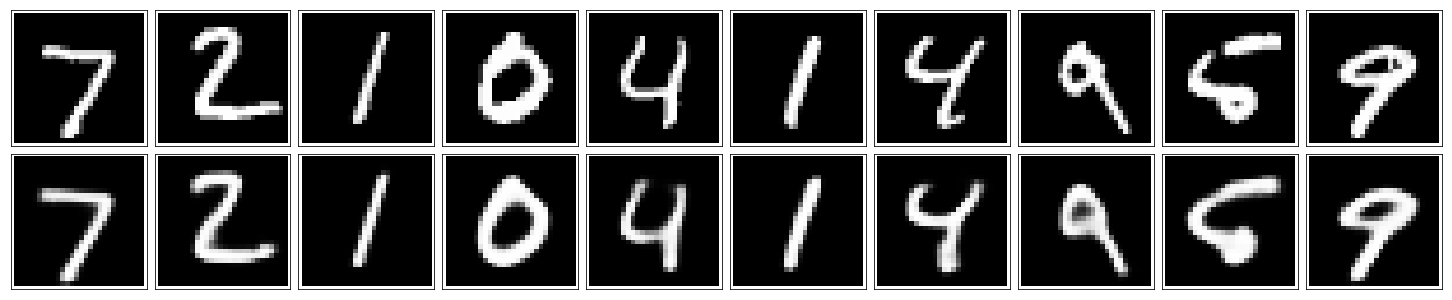

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = model.predict(in_imgs.reshape((10, 28, 28, 1)))

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [21]:
del model
K.clear_session()
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

## Using UpSampling

In [22]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = Input(shape = [28, 28, 1], dtype='float32', name='input')


#keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
#keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)
#keras.layers.UpSampling2D(size=(2, 2), data_format=None)



### Encoder
conv1 = Conv2D(32, (5, 5), padding='same', strides=(1, 1), activation='relu')(inputs_)
# Now 28x28x32

maxpool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv1)
# Now 14x14x32

conv2 = Conv2D(32, (5, 5), padding='same', strides=(1, 1), activation='relu')(maxpool1)
# Now 14x14x32

maxpool2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv2)
# Now 7x7x32

encoded = Conv2D(16, (5, 5), padding='same', strides=(1, 1), activation='relu')(maxpool2)
# Now 7x7x16

#encoded = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv3)
# Now 4x4x16



### Decoder

upsample1 = Lambda(lambda image: K.tf.image.resize_images(image, (7, 7)))(encoded)
# Now 7x7x16

conv4 = Conv2D(16, (5, 5), padding='same', strides=(1, 1), activation='relu')(upsample1)
# Now 7x7x16

upsample2 = Lambda(lambda image: K.tf.image.resize_images(image, (14, 14)))(conv4)
# Now 14x14x16

conv5 = Conv2D(32, (5, 5), padding='same', strides=(1, 1), activation='relu')(upsample2)
# Now 14x14x32

upsample3 = Lambda(lambda image: K.tf.image.resize_images(image, (28, 28)))(conv5)
# Now 28x28x32

conv6 = Conv2D(32, (5, 5), padding='same', strides=(1, 1), activation='relu')(upsample3)
# Now 28x28x32

logits = Conv2D(1, (5, 5), padding='same', strides=(1, 1))(conv6)
#Now 28x28x1



# Pass logits through sigmoid to get reconstructed image
decoded = Activation('sigmoid')(logits)


model = Model(inputs=inputs_, outputs=decoded)
model.compile(loss=losses.binary_crossentropy, optimizer='Adam')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          12816     
_________________________________________________________________
lambda_1 (Lambda)            (None, 7, 7, 16)          0         
__________

In [23]:
sess = tf.Session()
K.set_session(sess)

In [24]:
batch = mnist.train.next_batch(mnist.train.num_examples)

epochs = 100
batch_size = 200
noise_factor = 0.5


imgs = batch[0].reshape((-1, 28, 28, 1))

# Add random noise to the input images
noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
# Clip the images to be between 0 and 1
noisy_imgs = np.clip(noisy_imgs, 0., 1.)


model.fit(noisy_imgs, imgs,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/100
60000/60000 [==============================] - 13s 211us/step - loss: 0.2103
Epoch 2/100
60000/60000 [==============================] - 12s 203us/step - loss: 0.1214
Epoch 3/100
60000/60000 [==============================] - 12s 203us/step - loss: 0.1112
Epoch 4/100
60000/60000 [==============================] - 12s 202us/step - loss: 0.1071
Epoch 5/100
60000/60000 [==============================] - 12s 202us/step - loss: 0.1046
Epoch 6/100
60000/60000 [==============================] - 12s 202us/step - loss: 0.1031
Epoch 7/100
60000/60000 [==============================] - 12s 202us/step - loss: 0.1016
Epoch 8/100
60000/60000 [==============================] - 12s 203us/step - loss: 0.1009
Epoch 9/100
60000/60000 [==============================] - 12s 202us/step - loss: 0.0999
Epoch 10/100
60000/60000 [==============================] - 12s 201us/step - loss: 0.0992
Epoch 11/100
60000/60000 [==============================] - 12s 201us/step - loss: 0.0986
Epoch 12/100
60000/

60000/60000 [==============================] - 12s 202us/step - loss: 0.0909
Epoch 93/100
60000/60000 [==============================] - 12s 203us/step - loss: 0.0908
Epoch 94/100
60000/60000 [==============================] - 12s 202us/step - loss: 0.0908
Epoch 95/100
60000/60000 [==============================] - 12s 203us/step - loss: 0.0908
Epoch 96/100
60000/60000 [==============================] - 12s 202us/step - loss: 0.0908
Epoch 97/100
60000/60000 [==============================] - 12s 203us/step - loss: 0.0907
Epoch 98/100
60000/60000 [==============================] - 12s 203us/step - loss: 0.0908
Epoch 99/100
60000/60000 [==============================] - 12s 203us/step - loss: 0.0907
Epoch 100/100
60000/60000 [==============================] - 12s 203us/step - loss: 0.0906


## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

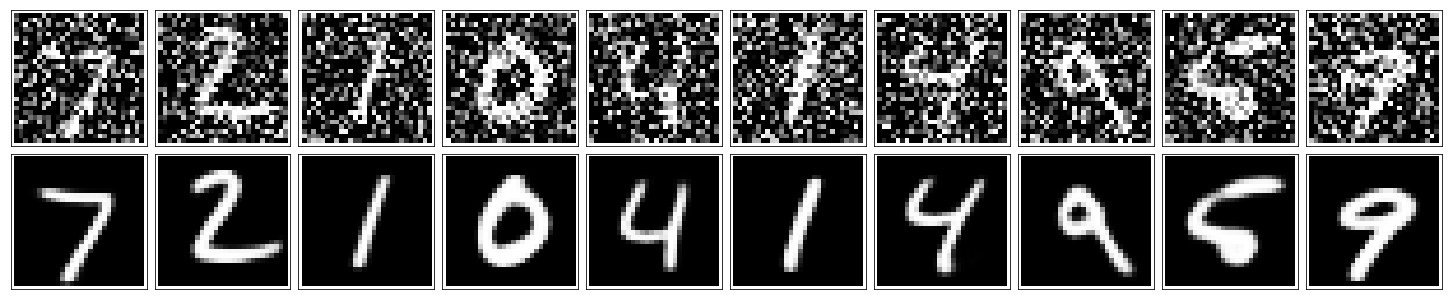

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = model.predict(in_imgs.reshape((10, 28, 28, 1)))

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [26]:
del model
K.clear_session()
sess.close()

## Using Resize

In [27]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = Input(shape = [28, 28, 1], dtype='float32', name='input')


#keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
#keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)
#keras.layers.UpSampling2D(size=(2, 2), data_format=None)



### Encoder
conv1 = Conv2D(32, (5, 5), padding='same', strides=(1, 1), activation='relu')(inputs_)
# Now 28x28x32

maxpool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv1)
# Now 14x14x32

conv2 = Conv2D(32, (5, 5), padding='same', strides=(1, 1), activation='relu')(maxpool1)
# Now 14x14x32

maxpool2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv2)
# Now 7x7x32

encoded = Conv2D(16, (5, 5), padding='same', strides=(1, 1), activation='relu')(maxpool2)
# Now 7x7x16

#encoded = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv3)
# Now 4x4x16



### Decoder

upsample1 = Lambda(lambda image: K.tf.image.resize_nearest_neighbor(image, (7, 7)))(encoded)
# Now 7x7x16

conv4 = Conv2D(16, (5, 5), padding='same', strides=(1, 1), activation='relu')(upsample1)
# Now 7x7x16

upsample2 = Lambda(lambda image: K.tf.image.resize_nearest_neighbor(image, (14, 14)))(conv4)
# Now 14x14x16

conv5 = Conv2D(32, (5, 5), padding='same', strides=(1, 1), activation='relu')(upsample2)
# Now 14x14x32

upsample3 = Lambda(lambda image: K.tf.image.resize_nearest_neighbor(image, (28, 28)))(conv5)
# Now 28x28x32

conv6 = Conv2D(32, (5, 5), padding='same', strides=(1, 1), activation='relu')(upsample3)
# Now 28x28x32

logits = Conv2D(1, (5, 5), padding='same', strides=(1, 1))(conv6)
#Now 28x28x1



# Pass logits through sigmoid to get reconstructed image
decoded = Activation('sigmoid')(logits)


model = Model(inputs=inputs_, outputs=decoded)
model.compile(loss=losses.binary_crossentropy, optimizer='Adam')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          12816     
_________________________________________________________________
lambda_1 (Lambda)            (None, 7, 7, 16)          0         
__________

In [28]:
sess = tf.Session()
K.set_session(sess)

In [29]:
batch = mnist.train.next_batch(mnist.train.num_examples)

epochs = 100
batch_size = 200
noise_factor = 0.5


imgs = batch[0].reshape((-1, 28, 28, 1))

# Add random noise to the input images
noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
# Clip the images to be between 0 and 1
noisy_imgs = np.clip(noisy_imgs, 0., 1.)


model.fit(noisy_imgs, imgs,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/100
60000/60000 [==============================] - 12s 204us/step - loss: 0.1952
Epoch 2/100
60000/60000 [==============================] - 12s 198us/step - loss: 0.1172
Epoch 3/100
60000/60000 [==============================] - 12s 198us/step - loss: 0.1088
Epoch 4/100
60000/60000 [==============================] - 12s 198us/step - loss: 0.1050
Epoch 5/100
60000/60000 [==============================] - 12s 198us/step - loss: 0.1028
Epoch 6/100
60000/60000 [==============================] - 12s 198us/step - loss: 0.1013
Epoch 7/100
60000/60000 [==============================] - 12s 198us/step - loss: 0.1000
Epoch 8/100
60000/60000 [==============================] - 12s 197us/step - loss: 0.0993
Epoch 9/100
60000/60000 [==============================] - 12s 196us/step - loss: 0.0984
Epoch 10/100
60000/60000 [==============================] - 12s 197us/step - loss: 0.0976
Epoch 11/100
60000/60000 [==============================] - 12s 196us/step - loss: 0.0972
Epoch 12/100
60000/

60000/60000 [==============================] - 12s 198us/step - loss: 0.0902
Epoch 93/100
60000/60000 [==============================] - 12s 197us/step - loss: 0.0903
Epoch 94/100
60000/60000 [==============================] - 12s 198us/step - loss: 0.0901
Epoch 95/100
60000/60000 [==============================] - 12s 198us/step - loss: 0.0901
Epoch 96/100
60000/60000 [==============================] - 12s 198us/step - loss: 0.0902
Epoch 97/100
60000/60000 [==============================] - 12s 194us/step - loss: 0.0901
Epoch 98/100
60000/60000 [==============================] - 12s 195us/step - loss: 0.0902
Epoch 99/100
60000/60000 [==============================] - 12s 196us/step - loss: 0.0900
Epoch 100/100
60000/60000 [==============================] - 12s 198us/step - loss: 0.0901


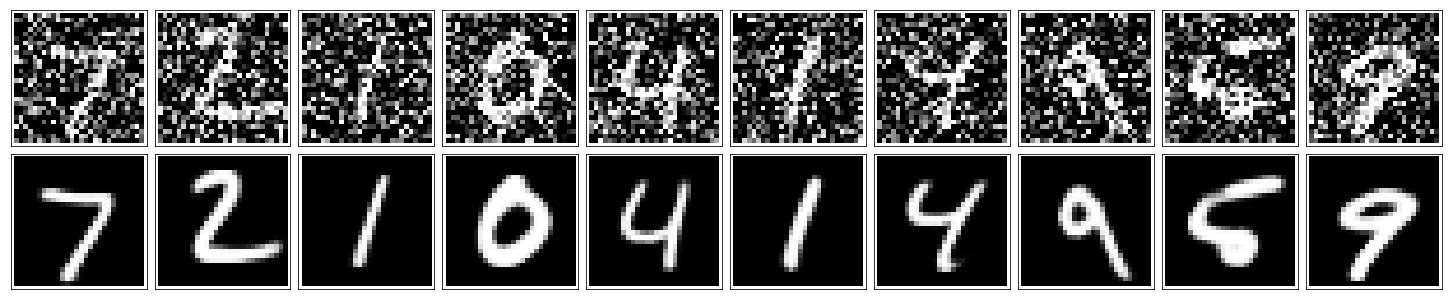

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = model.predict(in_imgs.reshape((10, 28, 28, 1)))

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [31]:
del model
K.clear_session()
sess.close()